<a href="https://colab.research.google.com/github/sundarjhu/Astrostatistics2025/blob/main/Lesson18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install astroquery scipy emcee
from astroquery.gaia import Gaia
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import emcee


# Bayesian Distance Estimation from Gaia DR3 Parallaxes

## 1. Bayes' Theorem and Statistical Perspectives
Bayesian inference provides a probabilistic framework for estimating model parameters given noisy data.

The fundamental rule is Bayes' theorem:
$
p(\theta|D) = \frac{p(D|\theta)p(\theta)}{p(D)}.
$
- **Posterior** $p(\theta|D)$: probability of parameters given the data.  
- **Likelihood** $p(D|\theta)$: probability of the data given parameters.  
- **Prior** $p(\theta)$: beliefs before seeing the data.  
- **Evidence** $p(D)$: normalization constant.

| Concept | Frequentist | Bayesian |
|----------|--------------|----------|
| Parameters | Fixed but unknown | Random variables |
| Probability | Long-run frequency | Degree of belief |
| Output | Point estimate + CI | Posterior distribution |

### Priors
- **Informative priors** encode astrophysical knowledge (e.g., Galactic scale height).  
- **Noninformative priors** impose minimal structure.  
- **Improper priors** cannot be normalized and must be used with care.



## 2. Parallax–Distance Background
Gaia measures parallaxes ($\varpi$) in milliarcseconds (mas). The distance in parsecs is $r = 1000 / \varpi$.
Because parallax errors are Gaussian, some measured parallaxes are negative. This does **not** imply unphysical distances—it's a result of measurement noise.
Direct inversion ($r = 1/\varpi$) fails for noisy or negative parallaxes.
Bayesian inference, with physically motivated priors, provides robust distance estimates.



## 3. The Bailer-Jones Prior
Bailer-Jones (2015, 2018) proposed the **exponentially decreasing space-density prior**:
$
p(r) \propto r^2 e^{-r/L}, \quad L = 1.35~\text{kpc}.
$
- The $r^2$ term accounts for the volume element.  
- The exponential term represents the decline of stellar density in the Galactic disk.  
This prior is *informative* but physically meaningful. It ensures distances remain finite and positive.



## 4. Query High-Quality Gaia DR3 Data
Retrieve 200 bright, well-measured Gaia DR3 sources.


In [4]:
query_good = '''
SELECT TOP 200 source_id, ra, dec, parallax, parallax_error, phot_g_mean_mag, ruwe
FROM gaiadr3.gaia_source
WHERE parallax_over_error > 10 AND ruwe < 1.4 AND phot_g_mean_mag < 14
'''
job = Gaia.launch_job_async(query_good)
good = job.get_results().to_pandas()
good['distance_frequentist'] = 1000.0 / good['parallax']
print(f"Retrieved {len(good)} sources with good parallaxes.")


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Retrieved 200 sources with good parallaxes.



## 5. Query Negative Parallaxes
Retrieve 200 Gaia sources with negative parallaxes to demonstrate the failure of direct inversion.


In [5]:

query_bad = '''
SELECT TOP 200 source_id, ra, dec, parallax, parallax_error, phot_g_mean_mag, ruwe
FROM gaiadr3.gaia_source
WHERE parallax < 0 AND parallax_error < 0.3 AND ruwe < 1.4 AND phot_g_mean_mag < 14
'''
job = Gaia.launch_job_async(query_bad)
bad = job.get_results().to_pandas()
bad['distance_frequentist'] = 1000.0 / bad['parallax']
print(f"Retrieved {len(bad)} sources with negative parallaxes.")


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Retrieved 200 sources with negative parallaxes.



## 6. Bayesian Fix (Grid Evaluation)
For a given parallax $\varpi$ and uncertainty $\sigma_\varpi$, compute the posterior:
$
p(r | \varpi, \sigma_\varpi) \propto \exp\!\left[-\frac{1}{2}\frac{(\varpi - 1/r)^2}{\sigma_\varpi^2}\right] r^2 e^{-r/L}.
$


/tmp/ipython-input-965176332.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  post /= np.trapz(post, r)


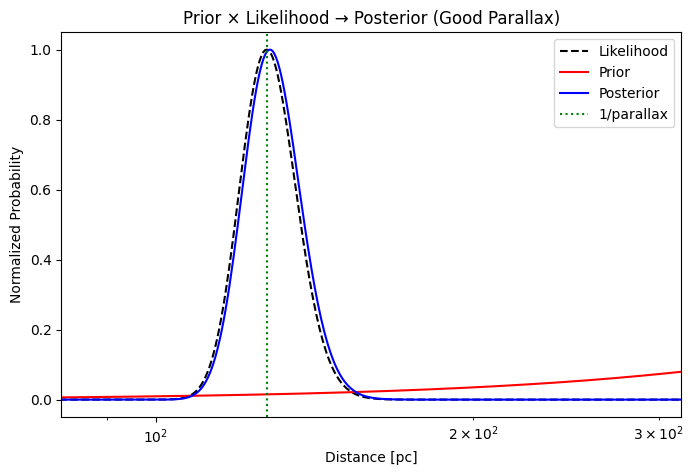

In [6]:

def posterior_grid(parallax, parallax_error, L=1350.0):
    r = np.linspace(0.01, 5000, 10000)
    like = norm.pdf(parallax, 1e3/r, parallax_error)
    prior = r**2 * np.exp(-r/L)
    post = like * prior
    post /= np.trapz(post, r)
    return r, like, prior/np.max(prior), post

ex = good.iloc[0]
r, like, prior, post = posterior_grid(ex.parallax, ex.parallax_error)
plt.figure(figsize=(8,5))
plt.plot(r, like/np.max(like), 'k--', label='Likelihood')
plt.plot(r, prior, 'r-', label='Prior')
plt.plot(r, post/np.max(post), 'b-', label='Posterior')
plt.axvline(1000/ex.parallax, color='g', ls=':', label='1/parallax')
plt.xlabel('Distance [pc]')
plt.ylabel('Normalized Probability')
plt.legend(); plt.title('Prior × Likelihood → Posterior (Good Parallax)')
plt.xscale('log')
k = np.nonzero(post > 1e-2 * np.max(post))[0]
plt.xlim(0.75 * r[k[0]], 2 * r[k[-1]])
plt.show()



## 7. Bayesian Sampling with `emcee`
To confirm the grid result, sample the posterior with `emcee`.


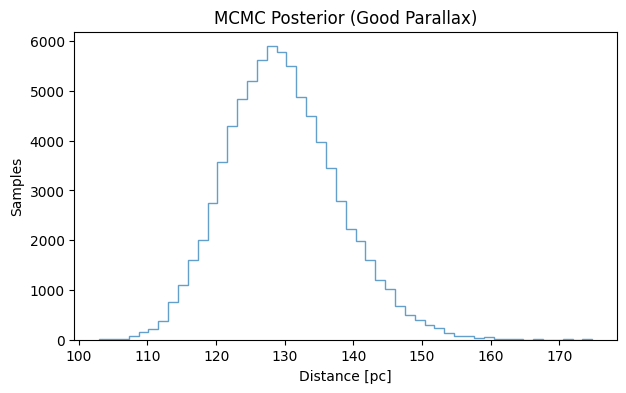

In [7]:

def log_posterior(theta, parallax, parallax_error, L=1350.0):
    r = theta[0]
    if r <= 0:
        return -np.inf
    prior = 2*np.log(r) - r/L
    like = -0.5*((parallax - 1e3/r)**2 / parallax_error**2)
    return prior + like

init = 1000/ex.parallax
ndim, nwalkers = 1, 32
p0 = init + 10*np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(ex.parallax, ex.parallax_error))
sampler.run_mcmc(p0, 3000, progress=False)
samples = sampler.get_chain(discard=500, flat=True)
plt.figure(figsize=(7,4))
plt.hist(samples, bins=50, color='C0', alpha=0.7, histtype='step')
plt.xlabel('Distance [pc]'); plt.ylabel('Samples'); plt.title('MCMC Posterior (Good Parallax)')
plt.show()



## 8. Comparing All Methods
Compare $1/\varpi$ and Bayesian distances for good and negative parallaxes.


/tmp/ipython-input-965176332.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  post /= np.trapz(post, r)
/tmp/ipython-input-2308386034.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(r * post, r)
/tmp/ipython-input-965176332.py:6: RuntimeWarning: invalid value encountered in divide
  post /= np.trapz(post, r)


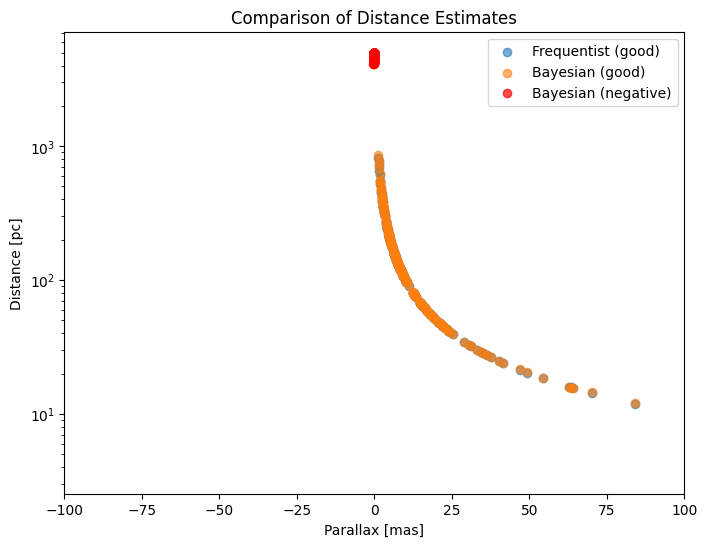

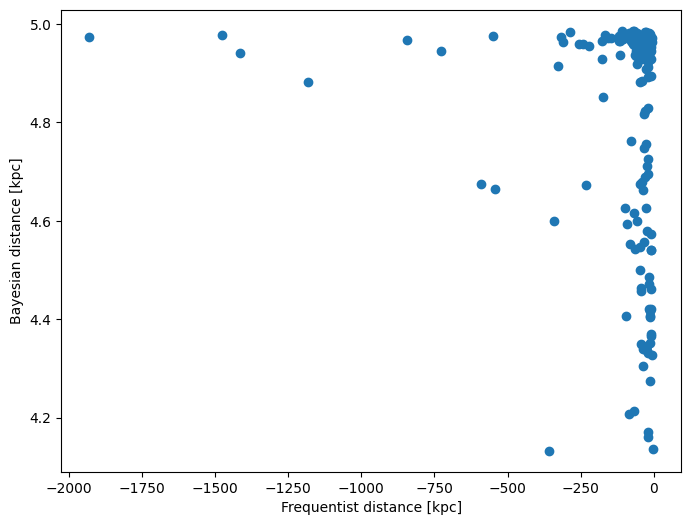

In [11]:

def posterior_mean(parallax, parallax_error, L=1350.0):
    r, _, _, post = posterior_grid(parallax, parallax_error, L)
    return np.trapz(r * post, r)

good['distance_bayes'] = [posterior_mean(p, e) for p,e in zip(good.parallax, good.parallax_error)]
bad['distance_bayes'] = [posterior_mean(p, e) for p,e in zip(bad.parallax, bad.parallax_error)]

plt.figure(figsize=(8,6))
plt.scatter(good.parallax, good.distance_frequentist, label='Frequentist (good)', alpha=0.6, zorder=1)
plt.scatter(good.parallax, good.distance_bayes, label='Bayesian (good)', alpha=0.6, zorder=2)
plt.scatter(bad.parallax, bad.distance_bayes, label='Bayesian (negative)', color='r', alpha=0.7, zorder=100)
plt.xlabel('Parallax [mas]'); plt.ylabel('Distance [pc]')
plt.legend(); plt.title('Comparison of Distance Estimates')
# plt.xscale('log')
plt.yscale('log')
plt.xlim(-100, 100)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(bad.distance_frequentist / 1e3, bad.distance_bayes / 1e3)
plt.xlabel('Frequentist distance [kpc]')
plt.ylabel('Bayesian distance [kpc]')
plt.show()



## 9. Discussion
- Bayesian inference ensures positive, finite distances even for negative parallaxes.  
- The prior $r^2 e^{-r/L}$ embeds Galactic structure.  
- For high-S/N data, the posterior ≈ frequentist inversion.  
- This method underlies the Bailer-Jones Gaia DR3 distance catalog.



## 10. Exercises
1. Change $L$ to 0.5 and 5 kpc and observe the posterior shift.  
2. Use a uniform prior in $r$ and compare results.  
3. Increase parallax uncertainty and inspect posterior broadening.  
4. For a negative parallax, compare posterior mean, median, and mode.  
5. Try sampling a negative-parallax posterior with `emcee`.
